# Predicting House Sale Prices

In this project I will use Line Regression model to try and predict prices of houses. I will work with housing data for the city of Ames, Iowa, United States from 2006 to 2010. You can read more about why the data was collected [here](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627). The information about the columns in the dataset is available [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

For this project I will try to build a complete pipeline of three functions that
- take a dataset and clean it from missing values, 
- select the appropriate features, 
- and then train and test the Linear Regression model. 

In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
%matplotlib inline

In [281]:
data = pd.read_csv('AmesHousing.tsv', sep='\t')
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [288]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

Below is the initial skeleton form of the functions:

In [222]:
def transform_features(df):
    """
    Returns the same df
    """
    return df

def select_features(df):
    """
    Returns the Gr Liv Area and SalePrice columns 
    from the train data frame
    """
    selected = df[['Gr Liv Area', 'SalePrice']]
    return selected

def train_and_test(df):
    """
    Trains a model using all numerical columns except the SalePrice column (the target column) from the data frame returned from select_features()
    Tests the model on the test set and returns the RMSE value
    """
    train = df[:1460]
    test = df[1460:]
    numerical_cols = list(train.select_dtypes(include='int').columns)
    numerical_cols.remove('SalePrice')
    target = 'SalePrice'
    lr = LinearRegression()
    lr.fit(train[numerical_cols], train[target])
    predictions = lr.predict(test[numerical_cols])
    rmse = np.sqrt(mean_squared_error(test[target], predictions))
    return rmse

transform_df = transform_features(data)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

57088.25161263909

## Feature Transformation

We will experiment with the data to update `transform_features()` function so that it cleans the dataset in the following way:
- Drop rowns that have more than 5% of missing values;
- Fill the missing values in the rest of the columns with the column's mode (the most popular value);
- Create new more informative features by combining other features;
- Drop any columns that leak information about house sales. 

In [223]:
clean_data = data.copy()

#Dropping columns that have more than 5% of missing data
data_nulls = clean_data.isnull().sum()
cols_to_remove = data_nulls[data_nulls>=len(data)*0.05].index
clean_data = clean_data.drop(cols_to_remove, axis=1)
clean_data.isnull().sum().sort_values(ascending=False)

Bsmt Exposure     83
BsmtFin Type 2    81
Bsmt Cond         80
Bsmt Qual         80
BsmtFin Type 1    80
                  ..
Exter Cond         0
Foundation         0
PID                0
Heating            0
SalePrice          0
Length: 71, dtype: int64

In [224]:
#In columns with less than 5% missing data, fill the missing data with the column's mode
data_nulls = clean_data.isnull().sum()
selected_cols = data_nulls[(data_nulls < len(clean_data)*0.05)&(data_nulls>0)].index
clean_data.fillna(clean_data[selected_cols].mode(), inplace=True)
clean_data[selected_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Mas Vnr Type    2907 non-null   object 
 1   Mas Vnr Area    2907 non-null   float64
 2   Bsmt Qual       2850 non-null   object 
 3   Bsmt Cond       2850 non-null   object 
 4   Bsmt Exposure   2847 non-null   object 
 5   BsmtFin Type 1  2850 non-null   object 
 6   BsmtFin SF 1    2929 non-null   float64
 7   BsmtFin Type 2  2849 non-null   object 
 8   BsmtFin SF 2    2929 non-null   float64
 9   Bsmt Unf SF     2929 non-null   float64
 10  Total Bsmt SF   2929 non-null   float64
 11  Electrical      2929 non-null   object 
 12  Bsmt Full Bath  2928 non-null   float64
 13  Bsmt Half Bath  2928 non-null   float64
 14  Garage Cars     2929 non-null   float64
 15  Garage Area     2929 non-null   float64
dtypes: float64(9), object(7)
memory usage: 366.4+ KB


It looks like for some columns there are several modes, so we will have to use a slightly more complex way of filling the NaN values. 

In [225]:
modes = clean_data[selected_cols].mode().to_dict(orient='records')[0]
modes

{'Mas Vnr Type': 'None',
 'Mas Vnr Area': 0.0,
 'Bsmt Qual': 'TA',
 'Bsmt Cond': 'TA',
 'Bsmt Exposure': 'No',
 'BsmtFin Type 1': 'GLQ',
 'BsmtFin SF 1': 0.0,
 'BsmtFin Type 2': 'Unf',
 'BsmtFin SF 2': 0.0,
 'Bsmt Unf SF': 0.0,
 'Total Bsmt SF': 0.0,
 'Electrical': 'SBrkr',
 'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Garage Cars': 2.0,
 'Garage Area': 0.0}

In [226]:
clean_data = clean_data.fillna(modes)
clean_data[selected_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Mas Vnr Type    2930 non-null   object 
 1   Mas Vnr Area    2930 non-null   float64
 2   Bsmt Qual       2930 non-null   object 
 3   Bsmt Cond       2930 non-null   object 
 4   Bsmt Exposure   2930 non-null   object 
 5   BsmtFin Type 1  2930 non-null   object 
 6   BsmtFin SF 1    2930 non-null   float64
 7   BsmtFin Type 2  2930 non-null   object 
 8   BsmtFin SF 2    2930 non-null   float64
 9   Bsmt Unf SF     2930 non-null   float64
 10  Total Bsmt SF   2930 non-null   float64
 11  Electrical      2930 non-null   object 
 12  Bsmt Full Bath  2930 non-null   float64
 13  Bsmt Half Bath  2930 non-null   float64
 14  Garage Cars     2930 non-null   float64
 15  Garage Area     2930 non-null   float64
dtypes: float64(9), object(7)
memory usage: 366.4+ KB


Now we need to delete the columns that leak information about the sale: Year, Month, Order, PID. But we will first create other columns that may be used as features: one for how lond had passed between the sale and the last renovation, and the other for how old the house was when sold.

In [227]:
clean_data['years_since_remod'] = clean_data['Yr Sold'] - clean_data['Year Remod/Add']
clean_data['years_until_sold'] = clean_data['Yr Sold'] - clean_data['Year Built']

Both of these column can't have negative values. So we will check if all the rows comply with this requirement. If not, we will delete the rows.

In [228]:
clean_data[clean_data['years_since_remod']<0]

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,years_since_remod,years_until_sold
1702,1703,528120010,60,RL,16659,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,6,2007,New,Partial,260116,-1,0
2180,2181,908154195,20,RL,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,17000,10,2007,New,Partial,183850,-2,-1
2181,2182,908154205,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,...,0,0,0,10,2007,New,Partial,184750,-1,0


In [229]:
clean_data[clean_data['years_until_sold']<0]

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,years_since_remod,years_until_sold
2180,2181,908154195,20,RL,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,17000,10,2007,New,Partial,183850,-2,-1


In [230]:
clean_data = clean_data.drop([1702, 2180, 2181], axis=0)
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 73 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Order              2927 non-null   int64  
 1   PID                2927 non-null   int64  
 2   MS SubClass        2927 non-null   int64  
 3   MS Zoning          2927 non-null   object 
 4   Lot Area           2927 non-null   int64  
 5   Street             2927 non-null   object 
 6   Lot Shape          2927 non-null   object 
 7   Land Contour       2927 non-null   object 
 8   Utilities          2927 non-null   object 
 9   Lot Config         2927 non-null   object 
 10  Land Slope         2927 non-null   object 
 11  Neighborhood       2927 non-null   object 
 12  Condition 1        2927 non-null   object 
 13  Condition 2        2927 non-null   object 
 14  Bldg Type          2927 non-null   object 
 15  House Style        2927 non-null   object 
 16  Overall Qual       2927 

In [231]:
#Drop the columns leaking data or not useful anymore
clean_data = clean_data.drop(['PID', 'Order', 'Mo Sold', 'Sale Condition', 'Sale Type', 'Yr Sold', 'Year Remod/Add', 'Year Built'], axis=1)
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 65 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MS SubClass        2927 non-null   int64  
 1   MS Zoning          2927 non-null   object 
 2   Lot Area           2927 non-null   int64  
 3   Street             2927 non-null   object 
 4   Lot Shape          2927 non-null   object 
 5   Land Contour       2927 non-null   object 
 6   Utilities          2927 non-null   object 
 7   Lot Config         2927 non-null   object 
 8   Land Slope         2927 non-null   object 
 9   Neighborhood       2927 non-null   object 
 10  Condition 1        2927 non-null   object 
 11  Condition 2        2927 non-null   object 
 12  Bldg Type          2927 non-null   object 
 13  House Style        2927 non-null   object 
 14  Overall Qual       2927 non-null   int64  
 15  Overall Cond       2927 non-null   int64  
 16  Roof Style         2927 

Now we will update the `transform_features()` funtion.

In [232]:
def transform_features(df):
    """
    returns clean dataframe without missing values 
    """
    new_df = df.copy()
    #Removing columns with more than 5% missing values
    data_nulls = new_df.isnull().sum()
    cols_to_remove = data_nulls[data_nulls>=len(new_df)*0.05].index
    new_df = new_df.drop(cols_to_remove, axis=1)
    
    #In columns with less than 5% missing data, fill the missing data with the column's mode
    data_nulls = new_df.isnull().sum()
    selected_cols = data_nulls[(data_nulls < len(new_df)*0.05)&(data_nulls>0)].index
    modes = new_df[selected_cols].mode().to_dict(orient='records')[0]
    new_df[selected_cols] = new_df[selected_cols].fillna(modes)
    
    #Make new informative columns
    new_df['years_since_remod'] = new_df['Yr Sold'] - new_df['Year Remod/Add']
    new_df['years_until_sold'] = new_df['Yr Sold'] - new_df['Year Built']

    #Drop columns that have negative values in these columns
    new_def = new_df.drop([1702, 2180, 2181], axis=0)

    #Drop columns that aren't useful for ML or leak information about the sale
    new_df = new_df.drop(['PID', 'Order', 'Mo Sold', 'Sale Condition', 'Sale Type', 'Yr Sold', 'Year Remod/Add', 'Year Built'], axis=1)

    return new_df

def select_features(df):
    """
    returns the Gr Liv Area and SalePrice columns 
    from the train data frame
    """
    selected = df[['Gr Liv Area', 'SalePrice']]
    return selected

def train_and_test(df):
    """
    Trains a model using all numerical columns except the SalePrice column (the target column) from the data frame returned from select_features()
    Tests the model on the test set and returns the RMSE value
    """
    train = df[:1460]
    test = df[1460:]
    numerical_cols = list(train.select_dtypes(include='int').columns)
    numerical_cols.remove('SalePrice')
    target = 'SalePrice'
    lr = LinearRegression()
    lr.fit(train[numerical_cols], train[target])
    predictions = lr.predict(test[numerical_cols])
    rmse = np.sqrt(mean_squared_error(test[target], predictions))
    return rmse

transform_df = transform_features(data)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

print("Root Square Error: ", rmse)

Root Square Error:  57088.25161263909


## Feature Selection

For numeric features we will compute correlations between these features and `SalePrice` and get features that have more than 0.4 correlation coefficient. 

In [233]:
numeric_data = clean_data.select_dtypes(include=['integer', 'float'])
corrs = numeric_data.corr()
price_corrs = corrs['SalePrice'].abs().sort_values(ascending=False)
corrs_above_04 = price_corrs[price_corrs>0.4]
corrs_above_04

SalePrice            1.000000
Overall Qual         0.801206
Gr Liv Area          0.717596
Garage Cars          0.648361
Total Bsmt SF        0.644012
Garage Area          0.641425
1st Flr SF           0.635185
years_until_sold     0.558979
Full Bath            0.546118
years_since_remod    0.534985
Mas Vnr Area         0.506983
TotRms AbvGrd        0.498574
Fireplaces           0.474831
BsmtFin SF 1         0.439284
Name: SalePrice, dtype: float64

<AxesSubplot:>

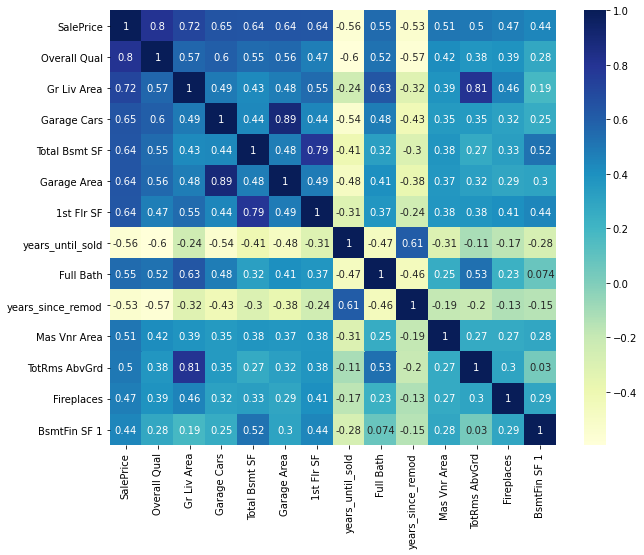

In [234]:
numeric_data = numeric_data[corrs_above_04.index]
new_corrs = numeric_data.corr()
fig, ax = plt.subplots(figsize=(10,8))  
sns.heatmap(new_corrs, cmap="YlGnBu",annot=True, ax=ax)

Three sets of columns are strongly correlated (above 0.7): `Garage Cars` and `Garage Area`, `Total Bsmt SF` and `1st Flr SF`, `Gr Liv Area` and `TotRms AbvGrd`. We will only leave one column from both sets. The one that has stronger correlation with `SalePrice`.

In [235]:
numeric_features = numeric_data.drop(['Garage Area', '1st Flr SF', 'TotRms AbvGrd'], axis=1)
numeric_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SalePrice          2927 non-null   int64  
 1   Overall Qual       2927 non-null   int64  
 2   Gr Liv Area        2927 non-null   int64  
 3   Garage Cars        2927 non-null   float64
 4   Total Bsmt SF      2927 non-null   float64
 5   years_until_sold   2927 non-null   int64  
 6   Full Bath          2927 non-null   int64  
 7   years_since_remod  2927 non-null   int64  
 8   Mas Vnr Area       2927 non-null   float64
 9   Fireplaces         2927 non-null   int64  
 10  BsmtFin SF 1       2927 non-null   float64
dtypes: float64(4), int64(7)
memory usage: 274.4 KB


For text columns, we need to choose which of them to convert into dummy variables. 

In [236]:
nominal_data = clean_data.select_dtypes(include='object')
nominal_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   MS Zoning       2927 non-null   object
 1   Street          2927 non-null   object
 2   Lot Shape       2927 non-null   object
 3   Land Contour    2927 non-null   object
 4   Utilities       2927 non-null   object
 5   Lot Config      2927 non-null   object
 6   Land Slope      2927 non-null   object
 7   Neighborhood    2927 non-null   object
 8   Condition 1     2927 non-null   object
 9   Condition 2     2927 non-null   object
 10  Bldg Type       2927 non-null   object
 11  House Style     2927 non-null   object
 12  Roof Style      2927 non-null   object
 13  Roof Matl       2927 non-null   object
 14  Exterior 1st    2927 non-null   object
 15  Exterior 2nd    2927 non-null   object
 16  Mas Vnr Type    2927 non-null   object
 17  Exter Qual      2927 non-null   object
 18  Exter Co

We will exclude the columns that have more than 10 unique values (number chosen arbitrarily, can be changed).

In [237]:
categorical = []
not_categorical = []

for column in nominal_data.columns:
    num_unique = len(nominal_data[column].unique())
    if num_unique > 10:
        not_categorical.append(column)
    elif num_unique <= 10:
        categorical.append(column)

print("Categorical columns: ", categorical)
print('\n')
print("Nominal columns: ",not_categorical)

nominal_data = nominal_data[categorical]

Categorical columns:  ['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional', 'Paved Drive']


Nominal columns:  ['Neighborhood', 'Exterior 1st', 'Exterior 2nd']


Now we will find the columns with low variability (more than 90% of the same value) and exclude then as well.

In [238]:
above_90 = []
for column in nominal_data:
    counts = nominal_data[column].value_counts(normalize=True)
    for value in counts:
        if value >= 0.90:
            above_90.append(column)
        else:
            continue
       
nominal_data = nominal_data.drop(above_90, axis=1)
nominal_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   MS Zoning       2927 non-null   object
 1   Lot Shape       2927 non-null   object
 2   Land Contour    2927 non-null   object
 3   Lot Config      2927 non-null   object
 4   Condition 1     2927 non-null   object
 5   Bldg Type       2927 non-null   object
 6   House Style     2927 non-null   object
 7   Roof Style      2927 non-null   object
 8   Mas Vnr Type    2927 non-null   object
 9   Exter Qual      2927 non-null   object
 10  Exter Cond      2927 non-null   object
 11  Foundation      2927 non-null   object
 12  Bsmt Qual       2927 non-null   object
 13  Bsmt Exposure   2927 non-null   object
 14  BsmtFin Type 1  2927 non-null   object
 15  BsmtFin Type 2  2927 non-null   object
 16  Heating QC      2927 non-null   object
 17  Kitchen Qual    2927 non-null   object
dtypes: objec

We have too many text columns to convert them all into dummies. We will drop the columns that have missing values to reduce the list.

In [239]:
nominal_data.dropna(inplace=True, axis=1)
nominal_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   MS Zoning       2927 non-null   object
 1   Lot Shape       2927 non-null   object
 2   Land Contour    2927 non-null   object
 3   Lot Config      2927 non-null   object
 4   Condition 1     2927 non-null   object
 5   Bldg Type       2927 non-null   object
 6   House Style     2927 non-null   object
 7   Roof Style      2927 non-null   object
 8   Mas Vnr Type    2927 non-null   object
 9   Exter Qual      2927 non-null   object
 10  Exter Cond      2927 non-null   object
 11  Foundation      2927 non-null   object
 12  Bsmt Qual       2927 non-null   object
 13  Bsmt Exposure   2927 non-null   object
 14  BsmtFin Type 1  2927 non-null   object
 15  BsmtFin Type 2  2927 non-null   object
 16  Heating QC      2927 non-null   object
 17  Kitchen Qual    2927 non-null   object
dtypes: objec

In [240]:
nominal_dummies = pd.get_dummies(nominal_data)
nominal_dummies['SalePrice'] = numeric_data['SalePrice']
nom_corrs = nominal_dummies.corr()['SalePrice'].abs().sort_values(ascending=False)
noms_above_04 = nom_corrs[nom_corrs>0.4]
print(noms_above_04)

SalePrice           1.000000
Bsmt Qual_Ex        0.595796
Exter Qual_TA       0.591013
Kitchen Qual_Ex     0.540099
Kitchen Qual_TA     0.526714
Foundation_PConc    0.520974
Bsmt Qual_TA        0.500473
Exter Qual_Ex       0.484861
Heating QC_Ex       0.454492
Exter Qual_Gd       0.446338
Name: SalePrice, dtype: float64


Let us check for collinearity between the columns.

<AxesSubplot:>

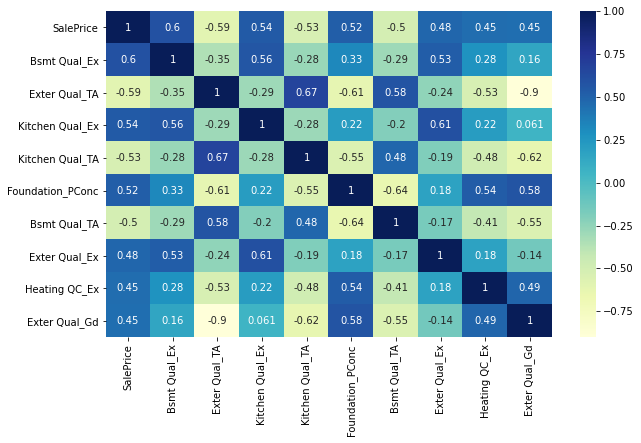

In [241]:
new_nom_corrs = nominal_dummies[noms_above_04.index].corr()
fig, ax = plt.subplots(figsize=(10,6))  
sns.heatmap(new_nom_corrs, cmap="YlGnBu", annot=True, ax=ax)

Some features are strongly correlated, but none of them above 0.7. We will leave these columns as they are for now and lower the treshold if the model performs poorly. 

In [242]:
def transform_features(df):
    """
    returns clean dataframe without missing values 
    """
    new_df = df.copy()
    #Removing columns with more than 5% missing values
    data_nulls = new_df.isnull().sum()
    cols_to_remove = data_nulls[data_nulls>=len(new_df)*0.05].index
    new_df = new_df.drop(cols_to_remove, axis=1)
    
    #In columns with less than 5% missing data, fill the missing data with the column's mode
    data_nulls = new_df.isnull().sum()
    selected_cols = data_nulls[(data_nulls < len(new_df)*0.05)&(data_nulls>0)].index
    modes = new_df[selected_cols].mode().to_dict(orient='records')[0]
    new_df[selected_cols] = new_df[selected_cols].fillna(modes)
    
    #Make new informative columns
    new_df['years_since_remod'] = new_df['Yr Sold'] - new_df['Year Remod/Add']
    new_df['years_until_sold'] = new_df['Yr Sold'] - new_df['Year Built']

    #Drop columns that have negative values in these columns
    new_def = new_df.drop([1702, 2180, 2181], axis=0)

    #Drop columns that aren't useful for ML or leak information about the sale
    new_df = new_df.drop(['PID', 'Order', 'Mo Sold', 'Sale Condition', 'Sale Type', 'Yr Sold', 'Year Remod/Add', 'Year Built'], axis=1)

    return new_df

def select_features(df):
    """
    returns the feature columns 
    from the transformed data frame
    """
    #Selecting numeric columns with more than 0.4 correlation coefficient
    numeric_data = data.select_dtypes(include=['integer', 'float'])
    corrs = numeric_data.corr()
    price_corrs = corrs['SalePrice'].abs().sort_values(ascending=False)
    corrs_above_04 = price_corrs[price_corrs>0.4]
    numeric_data = numeric_data[corrs_above_04.index]

    #Dropping columns that have collinearity with other features
    numeric_features = numeric_data.drop(['Garage Area', '1st Flr SF', 'TotRms AbvGrd'], axis=1)

    #Dropping the text columns that have too many categories (more than 10)
    nominal_data = df.select_dtypes(include='object')
    categorical = []
    not_categorical = []
    for column in nominal_data.columns:
        num_unique = len(nominal_data[column].unique())
        if num_unique > 10:
            not_categorical.append(column)
        elif num_unique <= 10:
            categorical.append(column)
    nominal_data = nominal_data[categorical]

    #Dropping the text columns that have more than 90% of the same value
    above_90 = []
    for column in nominal_data:
        counts = nominal_data[column].value_counts(normalize=True)
        for value in counts:
            if value >= 0.90:
                above_90.append(column)
            else:
                continue
        
    nominal_data = nominal_data.drop(above_90, axis=1)

    #Selecting only the dummy columns that have correlation more than 0.4 with the target column
    nominal_dummies = pd.get_dummies(nominal_data)
    nominal_dummies['SalePrice'] = numeric_data['SalePrice']
    nom_corrs = nominal_dummies.corr()['SalePrice'].abs().sort_values(ascending=False)
    noms_above_04 = nom_corrs[nom_corrs>0.4].drop('SalePrice')
    nominal_features = nominal_dummies[noms_above_04.index]
    
    selected_features = pd.concat([numeric_features, nominal_features], axis=1)
    return selected_features

def train_and_test(df):
    """
    Trains a model using all numerical columns except the SalePrice column (the target column) from the data frame returned from select_features()
    Tests the model on the test set and returns the RMSE value
    """
    train = df[:1460]
    test = df[1460:]
    numerical_cols = list(train.select_dtypes(include='int').columns)
    numerical_cols.remove('SalePrice')
    target = 'SalePrice'
    lr = LinearRegression()
    lr.fit(train[numerical_cols], train[target])
    predictions = lr.predict(test[numerical_cols])
    rmse = np.sqrt(mean_squared_error(test[target], predictions))
    return rmse

new_data = data.copy()
transform_df = transform_features(new_data)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)
print("Root Square Error: ", rmse)

Root Square Error:  40812.76413759153


## Training and Testing 

We managed to lower the error by 17 points thanks to feature selection. Let us now proceed to configure the training and testing function. We will upgrade it to use k-fold cross validation.

In [252]:
nominal_features = nominal_dummies[noms_above_04.index].drop('SalePrice', axis=1)
selected_data = pd.concat([numeric_features, nominal_features], axis=1)
features = selected_data.drop('SalePrice', axis=1)
features = features.columns
target = 'SalePrice'
selected_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SalePrice          2927 non-null   int64  
 1   Overall Qual       2927 non-null   int64  
 2   Gr Liv Area        2927 non-null   int64  
 3   Garage Cars        2927 non-null   float64
 4   Total Bsmt SF      2927 non-null   float64
 5   years_until_sold   2927 non-null   int64  
 6   Full Bath          2927 non-null   int64  
 7   years_since_remod  2927 non-null   int64  
 8   Mas Vnr Area       2927 non-null   float64
 9   Fireplaces         2927 non-null   int64  
 10  BsmtFin SF 1       2927 non-null   float64
 11  Bsmt Qual_Ex       2927 non-null   uint8  
 12  Exter Qual_TA      2927 non-null   uint8  
 13  Kitchen Qual_Ex    2927 non-null   uint8  
 14  Kitchen Qual_TA    2927 non-null   uint8  
 15  Foundation_PConc   2927 non-null   uint8  
 16  Bsmt Qual_TA       2927 

The train_and_test finction will have an optional k parameter. If k = 0 it will perform a simple holdout validation without shuffling the dataset. If k=1, it will shuffle the dataset and perform a simple cross validation. If k > 1 it will perform a cross validation with amount of folds = k.  

In [253]:
k=0
train = selected_data[:1460]
test = selected_data[1460:]
lr = LinearRegression()
lr.fit(train[features], train[target])
predictions = lr.predict(test[features])
rmse = np.sqrt(mean_squared_error(test[target], predictions))
print("Root Squared Error: ",rmse)

Root Squared Error:  33571.23608569663


In [257]:
k=1
shuffled= selected_data.sample(frac=1, random_state=1)
fold_one = shuffled[:1460]
fold_two = shuffled[1460:]
lr.fit(fold_one[features], fold_one[target])
predictions_1 = lr.predict(fold_two[features])
rmse_1 = np.sqrt(mean_squared_error(fold_two[target], predictions_1))

lr.fit(fold_two[features], fold_two[target])
predictions_2 = lr.predict(fold_one[features])
rmse_2 = np.sqrt(mean_squared_error(fold_one[target], predictions_2))
print("Average Root Square Error: ", np.mean([rmse_1, rmse_2]))

Average Root Square Error:  29862.926269965494


In [259]:
fold=4
kf = KFold(fold, shuffle=True, random_state=1)
model = LinearRegression()
mses = cross_val_score(model, selected_data[features], selected_data[target], scoring="neg_mean_squared_error", cv=kf)
rmses = np.sqrt(np.absolute(mses))
avg_rmse = np.mean(rmses)
avg_rmse

29491.058768330404

We will now update the `test_and_train` function in our pipeline.

In [280]:
def transform_features(df):
    """
    Returns clean dataframe without missing values 
    """
    new_df = df.copy()
    #Removing columns with more than 5% missing values
    data_nulls = new_df.isnull().sum()
    cols_to_remove = data_nulls[data_nulls>=len(new_df)*0.05].index
    new_df = new_df.drop(cols_to_remove, axis=1)
    
    #In columns with less than 5% missing data, fill the missing data with the column's mode
    data_nulls = new_df.isnull().sum()
    selected_cols = data_nulls[(data_nulls < len(new_df)*0.05)&(data_nulls>0)].index
    modes = new_df[selected_cols].mode().to_dict(orient='records')[0]
    new_df = new_df.fillna(modes)
    
    #Make new informative columns
    new_df['years_since_remod'] = new_df['Yr Sold'] - new_df['Year Remod/Add']
    new_df['years_until_sold'] = new_df['Yr Sold'] - new_df['Year Built']

    #Drop columns that have negative values in these columns
    new_df = new_df.drop([1702, 2180, 2181], axis=0)

    #Drop columns that aren't useful for ML or leak information about the sale
    new_df = new_df.drop(['PID', 'Order', 'Mo Sold', 'Sale Condition', 'Sale Type', 'Yr Sold', 'Year Remod/Add', 'Year Built'], axis=1)

    return new_df

def select_features(df):
    """
    Selects and returns a reduced DataFrame with only the necessary feature columns 
    from the transformed data frame
    """
    #Selecting numeric columns with more than 0.4 correlation coefficient
    numeric_features = df.select_dtypes(include=['integer', 'float'])
    corrs = numeric_features.corr()
    price_corrs = corrs['SalePrice'].abs().sort_values(ascending=False)
    corrs_above_04 = price_corrs[price_corrs>0.4]
    numeric_features = numeric_features[corrs_above_04.index]

    #Dropping columns that have collinearity with other features
    numeric_features = numeric_features.drop(['Garage Area', '1st Flr SF', 'TotRms AbvGrd'], axis=1)

    #Dropping the text columns that have too many categories (more than 10)
    nominal_data = df.select_dtypes(include='object')
    categorical = []
    not_categorical = []
    for column in nominal_data.columns:
        num_unique = len(nominal_data[column].unique())
        if num_unique > 10:
            not_categorical.append(column)
        elif num_unique <= 10:
            categorical.append(column)
    nominal_data = nominal_data[categorical]

    #Dropping the text columns that have more than 90% of the same value
    above_90 = []
    for column in nominal_data:
        counts = nominal_data[column].value_counts(normalize=True)
        for value in counts:
            if value >= 0.90:
                above_90.append(column)
            else:
                continue
        
    nominal_data = nominal_data.drop(above_90, axis=1)

    #Selecting only the dummy columns that have correlation more than 0.4 with the target column
    nominal_dummies = pd.get_dummies(nominal_data)
    nominal_dummies['SalePrice'] = numeric_data['SalePrice']
    nom_corrs = nominal_dummies.corr()['SalePrice'].abs().sort_values(ascending=False)
    noms_above_04 = nom_corrs[nom_corrs>0.4].drop('SalePrice')
    nominal_features = nominal_dummies[noms_above_04.index]
    
    selected_features = pd.concat([numeric_features, nominal_features], axis=1)
    return selected_features

def train_and_test(df, k=0):
    """
    Trains a Linear Regression model on given DataFrame using k amount of folds for cross-validation
    k is optional, deafult value is 0.
    """
    lr = LinearRegression()
    features = df.drop('SalePrice', axis=1)
    features = features.columns
    target = 'SalePrice'
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]
        lr.fit(train[features], train[target])
        predictions = lr.predict(test[features])
        rmse = np.sqrt(mean_squared_error(test[target], predictions))
        return rmse
    if k == 1:
        shuffled= df.sample(frac=1, random_state=1)
        fold_one = shuffled[:1460]
        fold_two = shuffled[1460:]
        lr.fit(fold_one[features], fold_one[target])
        predictions_1 = lr.predict(fold_two[features])
        rmse_1 = np.sqrt(mean_squared_error(fold_two[target], predictions_1))

        lr.fit(fold_two[features], fold_two[target])
        predictions_2 = lr.predict(fold_one[features])
        rmse_2 = np.sqrt(mean_squared_error(fold_one[target], predictions_2))
        return np.mean([rmse_1, rmse_2])
    if k > 1:
        kf = KFold(k, shuffle=True, random_state=1)
        mses = cross_val_score(model, df[features], df[target], scoring="neg_mean_squared_error", cv=kf)
        rmses = np.sqrt(np.absolute(mses))
        return np.mean(rmses)

new_data = data.copy()
transform_df = transform_features(new_data)
filtered_df = select_features(transform_df)
rmse_0 = train_and_test(filtered_df)
print("Average Root Square Error (K=(0): ", rmse_0)

rmse_10 = train_and_test(filtered_df, k=10)
print("Average Root Square Error (K=10): ", rmse_10)

rmse_20 = train_and_test(filtered_df, k=20)
print("Average Root Square Error (K=20): ", rmse_20)


Average Root Square Error (K=(0):  33571.23608569663
Average Root Square Error (K=10):  29116.02189814498
Average Root Square Error (K=20):  28530.176331172046
